In [93]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import seaborn
import cv2

from PIL import Image

In [95]:
%matplotlib inline

# Data

generate plots with corresponding masks

In [336]:
class PlotDataset(Dataset):
    def __init__(self, num_samples, transform=None, tolerance=5):
        self.num_samples = num_samples
        self.transform = transform
        self.tolerance = tolerance

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate random coefficients
        a1, a2 = np.random.uniform(-10, 10, 2)
        a3, a4, a5 = np.random.uniform(-1, 1, 3)
        
        # Generate x values
        x = np.linspace(-10, 10, 100)
        
        # Generate y values for linear and parabolic functions
        y_linear = a1 * x + a2
        y_parabolic = a3 * x**2 + a4 * x + a5
        
        # Create figure
        fig, ax = plt.subplots(figsize=(32, 32))
        ax.set_xlim(-10, 10)
        ax.set_ylim(-100, 100)
        
        # Plot the linear function
        line_color = np.random.rand(3,)
        ax.plot(x, y_linear, color=line_color)
        
        # Plot the parabolic function
        parab_color = np.random.rand(3,)
        ax.plot(x, y_parabolic, color=parab_color)
        
        # Save plot as image
        fig.canvas.draw()
        image = np.array(fig.canvas.renderer.buffer_rgba())
        plt.close(fig)
        
        # Convert RGBA to RGB
        image = image[:, :, :3]
        
        # Create mask
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        
        # Draw axes on mask (Assuming axes are black lines)
        mask[image[:, :, 0] == 0] = 1
        
        # Define a helper function for color matching with tolerance
        def within_tolerance(img, color, tol):
            return np.all(np.abs(img - np.array(color) * 255) <= tol, axis=-1)
        
        # Add linear function to mask
        mask[within_tolerance(image, line_color, self.tolerance)] = 2
        
        # Add parabolic function to mask
        mask[within_tolerance(image, parab_color, self.tolerance)] = 3
        
        # Apply transformations to image
        if self.transform:
            image = self.transform(image)
        
        # Convert mask to tensor manually to avoid scaling
        mask = torch.tensor(mask, dtype=torch.long)
        
        return image, mask

# Define transformations for the image
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create dataset and dataloader
dataset = PlotDataset(num_samples=1000, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [337]:
# Example usage
for images, masks in dataloader:
    print(images.shape, masks.shape)
    break

fig, axes = plt.subplots(4, 6, figsize=(9, 5))
axes = axes.ravel()

for i in range(6):
    axes[i].imshow(images[i].permute(1,2,0))
    axes[i].axis("off")
    axes[i+6].imshow(masks[i])
    axes[i+6].axis("off")
    axes[i + 6].set_title(f"{np.unique(masks[i])}")

for i in range(6):
    axes[i + 12].imshow(images[i + 6].permute(1,2,0))
    axes[i + 12].axis("off")
    axes[i + 18].imshow(masks[i + 6])
    axes[i + 18].axis("off")
    axes[i + 18].set_title(f"{np.unique(masks[i + 6])}")

plt.tight_layout()
plt.show()

torch.Size([32, 3, 3200, 3200]) torch.Size([32, 3200, 3200])


/var/folders/yt/vsz4v53j4bv674jbw4t304p80000gn/T/ipykernel_22286/3856567545.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


# Unet

In [224]:
from torch.functional import F
from torch import nn
from torchinfo import summary

CONV_KERNEL = (3, 3)
POOL_KERNEL = (2, 2)
STRIDE_SIZE = (1, 1)
PADDING_TYPE = 1

class DownBlock(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels, **kwargs):
        super(DownBlock, self).__init__(**kwargs)

        self.conv_1 = nn.Conv2d(in_channels=in_channels,
                                out_channels=out_channels,
                                kernel_size=CONV_KERNEL,
                                padding=PADDING_TYPE)
        self.conv_2 = nn.Conv2d(in_channels=out_channels,
                                out_channels=out_channels,
                                kernel_size=CONV_KERNEL,
                                padding=PADDING_TYPE)
        self.batch_1 = nn.BatchNorm2d(num_features=out_channels)
        self.batch_2 = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=POOL_KERNEL)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.relu(x)
        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x

def UpperBlockCustom(ConvTranspose, in_channels, out_channels):
    class UpperBlock(nn.Module):
        def __init__(self, in_channels: int, out_channels: int, **kwargs):
            super(UpperBlock, self).__init__(**kwargs)
            self.convT = ConvTranspose(in_channels=in_channels,
                                       out_channels=out_channels,
                                       kernel_size=CONV_KERNEL,
                                       stride=STRIDE_SIZE,
                                       padding=PADDING_TYPE)

        def forward(self, x, w=None):
            if w is not None:
                x = self.convT(x, w)
            else:
                x = self.convT(x)
            s = x.shape[2:]
            x = F.interpolate(x,
                              size=(s[0] * 2, s[1] * 2),
                              mode='bilinear',
                              align_corners=False)
            return x

    return UpperBlock(in_channels, out_channels)

n = 6
class UNet(nn.Module):

    def __init__(self, depth: int = 3, **kwargs):
        super(UNet, self).__init__(**kwargs)
        self.depth = depth
        self.down_blocks = nn.ModuleDict()
        self.down_blocks[str(0)] = DownBlock(in_channels=1,
                                        out_channels=64)
        n_feat = 64
        for i in range(1, depth):
            self.down_blocks[str(i)] = DownBlock(in_channels=n_feat,
                                            out_channels=2 * n_feat)
            n_feat *= 2

        self.up_block = nn.ModuleDict()
        self.up_block[str(0)] = UpperBlockCustom(nn.ConvTranspose2d,
                                            64, 1)
        n_feat = 64 * (2 ** (depth - 1)) // 2
        for i in range(1, depth):
            self.up_block[str(depth-i)] = UpperBlockCustom(nn.ConvTranspose2d,
                                                  2 * n_feat, n_feat)
            n_feat //= 2

    def forward(self, x):
        x = self.down_blocks[str(0)](x)
        for i in range(1, self.depth):
            x = self.down_blocks[str(i)](x)
        for i in range(1, self.depth):
            x = self.up_block[str(self.depth - i)](x)
        x = self.up_block[str(0)](x)
        return x

model = UNet(depth=3)
summary(model, input_size=(1, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 128, 128]          --
├─ModuleDict: 1-1                        --                        --
│    └─DownBlock: 2-1                    [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 64, 128, 128]         640
│    │    └─BatchNorm2d: 3-2             [1, 64, 128, 128]         128
│    │    └─ReLU: 3-3                    [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-4                  [1, 64, 128, 128]         36,928
│    │    └─BatchNorm2d: 3-5             [1, 64, 128, 128]         128
│    │    └─ReLU: 3-6                    [1, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-7               [1, 64, 64, 64]           --
│    └─DownBlock: 2-2                    [1, 128, 32, 32]          --
│    │    └─Conv2d: 3-8                  [1, 128, 64, 64]          73,856
│    │    └─BatchNorm2d: 3-9             [1, 128, 64, 64]          256
│  

In [233]:
target = torch.randint(0, 2, (32, 128, 128))
target.shape

torch.Size([32, 128, 128])

In [255]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the Dice Loss for multi-class segmentation
class DiceLoss(nn.Module):
    def __init__(self, num_classes, smooth=1):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, logits, targets):
        # Apply softmax to get probabilities
        logits = F.softmax(logits, dim=1)
        
        # One-hot encode the targets
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).permute(0, 3, 1, 2).float()
        
        # Compute Dice loss
        intersection = (logits * targets_one_hot).sum(dim=(2, 3))
        union = logits.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        
        return 1 - dice.mean()

# Define the Combined Loss function
class CombinedLoss(nn.Module):
    def __init__(self, num_classes, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss(num_classes)
        self.ce_loss = nn.CrossEntropyLoss()
        self.alpha = alpha

    def forward(self, logits, targets):
        dice = self.dice_loss(logits, targets)
        ce = self.ce_loss(logits, targets)
        return self.alpha * ce + (1 - self.alpha) * dice

# Dummy model output and target for demonstration
num_classes = 4  # For example, background, axes, linear plot, parabolic plot
output = torch.randn(32, num_classes, 128, 128)  # Model output logits
target = torch.randint(0, num_classes, (32, 128, 128))  # Ground truth mask

# Ensure target is a LongTensor containing class indices
target = target.long()

# Initialize the combined loss function
criterion = CombinedLoss(num_classes)

# Compute the loss
loss = criterion(output, target)
print(f"Loss: {loss.item()}")

Loss: 1.2364288568496704


# Test

In [261]:
from models_zoo.unet import UNet
from data.data import create_dataloader
from utils import plot_hystory, parse_arguments, count_torch_parameters

In [262]:
BATCH_SIZE = 4
IMG_SIZE = 128

In [263]:
test_dataloader = create_dataloader(num_samples=32, batch_size=BATCH_SIZE, shuffle=False, img_size=IMG_SIZE)

model = UNet()
summary(model, input_size=(1, 3, 128, 128))
count_torch_parameters(model)

Trainable parameters: 1703139
Non-trainable parameters: 0
Trainable weights (Mb): 6.812556
Non-trainable weights (Mb): 0.0


In [310]:
for X, mask in test_dataloader:
    pred = model(X)
    break

pred.shape, mask.shape

(torch.Size([4, 3, 128, 128]), torch.Size([4, 128, 128]))

# npy images

In [370]:
X = torch.randn(1, 1, 128, 128)
X = X.squeeze(dim=1)
X.shape


torch.Size([1, 128, 128])

In [363]:
for i in range(128):
    img = np.load(f'./data/train/image/{i}.npy')
    mask = np.load(f'./data/train/mask/{i}.npy')

    fig, axes = plt.subplots(1, 2, figsize=(9, 5))
    axes[0].imshow(np.transpose(img, (1,2,0)))
    axes[1].imshow(mask)
    axes[1].set_title(np.unique(mask))
    plt.savefig(f"./data/test_dataset/{i}.png")
    plt.close(fig)

In [362]:
i = 0
img = np.load(f'./data/train/image/{i}.npy')
mask = np.load(f'./data/train/mask/{i}.npy')
_, thresh = cv2.threshold(img, 0.7, 1, cv2.THRESH_BINARY)
print("---->", np.unique(thresh))

fig, axes = plt.subplots(1, 3, figsize=(9, 5))
axes[0].imshow(np.transpose(img, (1,2,0)))
axes[1].imshow(np.transpose(thresh, (1,2,0)))
axes[2].imshow(mask)
axes[2].set_title(np.unique(mask))

----> [0. 1.]


Text(0.5, 1.0, '[0 1 2]')

In [226]:
def to_edge(img):
    img = img.astype(np.uint8)
    edges = cv2.Canny(img, threshold1=50, threshold2=150)
    return edges

def preprocess_image(i):
    image = np.load(f"./data/train/image/{i}.npy") * 255
    for i in range(3):
        image[i] = to_edge(image[i])
    return image / 255.

edged = preprocess_image(1)

[0. 1.]


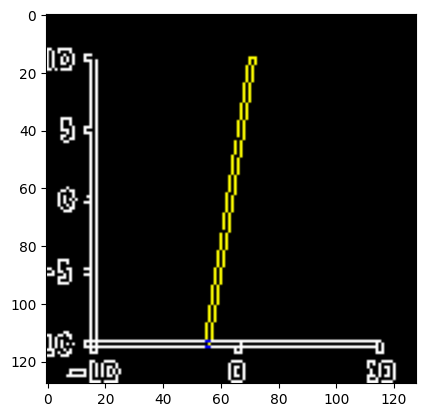

In [231]:
plt.imshow(np.transpose(edged, (1,2,0)))
print(np.unique(edged))

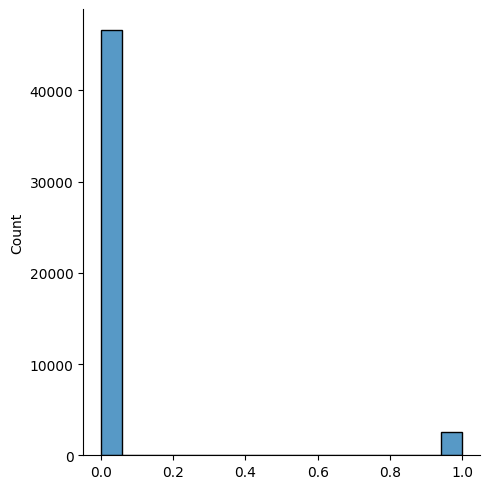

In [228]:
sns.displot(edged.reshape(-1))

(0.0, 100.0)

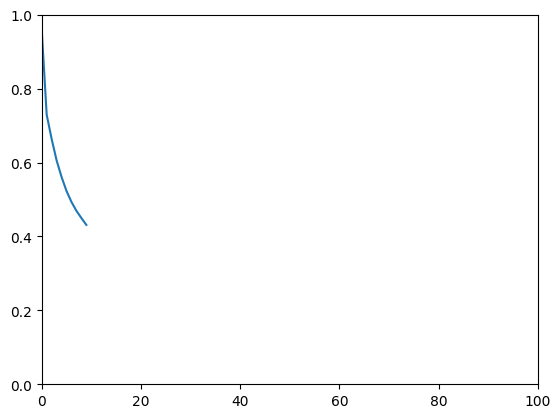

In [244]:
plt.plot([0.9585, 0.7294, 0.6637, 0.6058, 0.5609, 0.5228, 0.4932, 0.4692, 0.4497, 0.4312])
plt.ylim(0,1)
plt.xlim(0, 100)

# TestModel

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
from models_zoo.unet import UNet
from metrics.losses import DiceLoss
from data.data import create_dataloader
from metrics.losses import CombinedLoss
import cv2
import numpy as np
from train.train import Trainer
from utils import read_run_description, load_model
import matplotlib.pylab as plt

from torch.utils.data import Dataset, DataLoader

In [318]:
def test_step(loss_fn,
              dataloader):
    model.eval()
    step_loss = 0
    n = 0
    for X, masks in dataloader:
        X = X.type(torch.float32)
        masks = masks.type(torch.float32)
        X = X
        masks = masks
        pred = model(X)
        loss = loss_fn(pred, masks)
        step_loss += loss.item()
        n += 1
    print("Loss per test: ", step_loss / n)
    pred = pred.cpu()
    masks = masks.cpu()
    masks = masks.numpy()
    pred = torch.squeeze(pred, dim=-1)
    pred = pred.detach().numpy()
    _, axes = plt.subplots(4, 6, figsize=(10, 8))
    axes = axes.ravel()
    for i in range(6):
        axes[i + 0 * 6].imshow(pred[i][0])
        axes[i + 0 *6].axis("off")
        axes[i + 1 * 6].imshow(masks[i][0, :, :])
        axes[i + 1 * 6].axis("off")
        axes[i + 2 * 6].imshow(pred[i][1])
        axes[i + 2 * 6].axis("off")
        axes[i + 3 * 6].imshow(masks[i][1, :, :])
        axes[i + 3 * 6].axis("off")
    plt.tight_layout()
    plt.savefig("test_res.png")

In [314]:
model = UNet()
model = load_model(model, "16-16-25-07-2024.pth")

Models is loaded from:  16-16-25-07-2024.pth


Loss per test:  0.9720232933759689


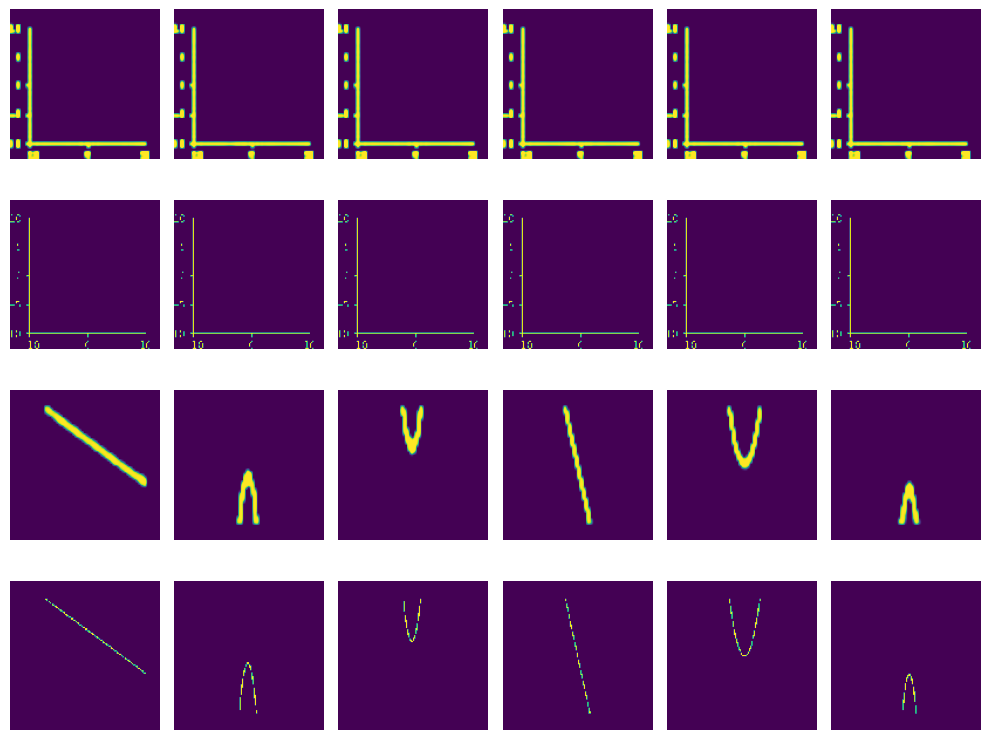

In [319]:
test_dataloader = create_dataloader(mode="test", num_samples=128, batch_size=32, shuffle=False, img_size=128)
test_step(DiceLoss(), test_dataloader)

# MaskPlot

fit with an overlaping line

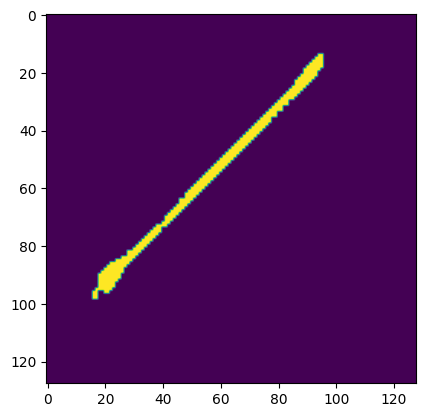

In [397]:
img, mask = next(iter(test_dataloader))
pred = model(img).detach().numpy()
selected = pred[0][1, :, :]
_, selected = cv2.threshold(selected, 0.9, 1, cv2.THRESH_BINARY)
plt.imshow(selected)

In [425]:
def lin_fn(x, a, b):
    return a * x + b

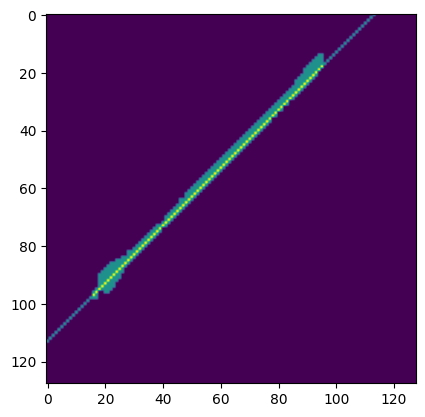

In [427]:
a, b = 1, 15
l_b, u_b = 0, 128

selected_c = selected.copy() * 0
for n in range(l_b, u_b):
    y_gen = lin_fn(n, a, b)
    bound = 128 - int(y_gen)
    if bound < l_b or bound > u_b:
        pass
    else:
        selected_c[n, bound] = 1

plt.imshow(selected_c + selected)

In [429]:
np.sum(selected * selected_c)

80.0

In [469]:
def fit(a, b):
    l_b, u_b = 0, 128
    tol = 2
    selected_c = selected.copy() * 0
    for n in range(l_b, u_b):
        y_gen = lin_fn(n, a, b)
        bound = 128 - int(y_gen)
        if bound < l_b or bound > u_b - 1:
            pass
        else:
            selected_c[n, bound] = 1
        for thick in range(tol):
            l_bound = 128 - int(y_gen) - thick
            u_bound = 128 - int(y_gen) + thick
            if l_bound < l_b or u_bound > u_b - 1:
                pass
            else:
                selected_c[n, l_bound] = 1
                selected_c[n, u_bound] = 1
    return np.sum(selected * selected_c)

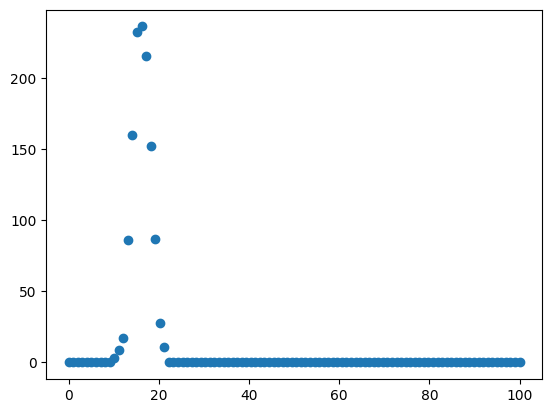

In [471]:
b = np.linspace(0, 100, 100)
iou = [fit(1, x) for x in b]
plt.plot(b, iou, "o")

resaling

In [42]:
img, mask = next(iter(test_dataloader))
mask = model(img).detach().numpy()
selected = mask[0][0, :, :]
#_, selected = cv2.threshold(selected, 0.9, 1, cv2.THRESH_BINARY)

Anchor is: (115, 17) with delta 98 that is scaled to 10
Each pixel is then scaled to 0.10204081632653061


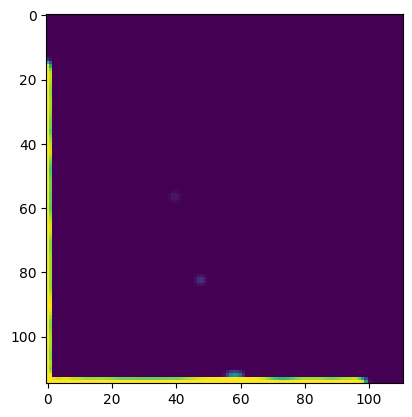

In [67]:
plt.imshow(selected[:115, 17:])
print(f"Anchor is: ({115}, {17}) with delta {115 - 17} that is scaled to {10}")
print(f"Each pixel is then scaled to {10/(115-17)}")

now lets draw a line accounting rescaling

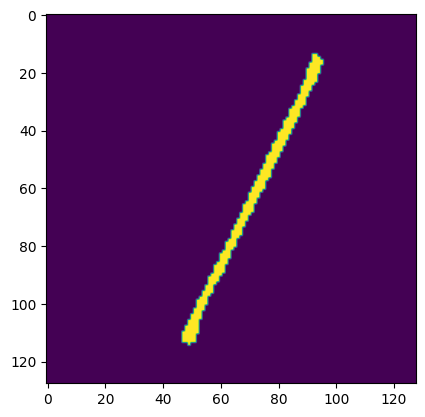

In [172]:
i = 0
for img, mask in test_dataloader:
     i += 1
     if i == 3:
        break
pred = model(img).detach().numpy()
selected = pred[0][1, :, :]
_, selected = cv2.threshold(selected, 0.9, 1, cv2.THRESH_BINARY)
plt.imshow(selected)

In [176]:
def lin_fn(x, a, b):
    a = a * 0.1
    b = b * 0.1
    return a * x + b

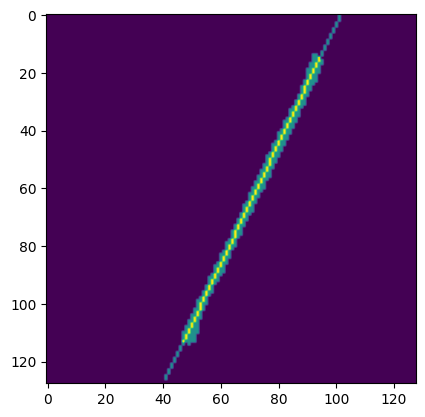

In [199]:
a, b = 4.8, 270
l_b, u_b = 0, 127

selected_c = selected.copy() * 0
for n in range(l_b, u_b):
    y_gen = lin_fn(n, a, b)
    bound = 128 - int(y_gen)
    if bound < l_b or bound > u_b:
        pass
    else:
        selected_c[n, bound] = 1

plt.imshow(selected_c + selected)

# Cv2

In [22]:
i = 0
img = np.load(f'./data/train/mask/{i}.npy')
len(img[img !=0]) / len(img[img == 0]) * 100

1.3391062316375446

In [150]:
i = 0
img = np.load(f'./data/train/image/{i}.npy')

In [151]:
selected = img
selected = np.transpose(selected, (1, 2, 0))
selected = selected[:, :, 0] - selected[:, :, 2]
selected = selected - selected.min()

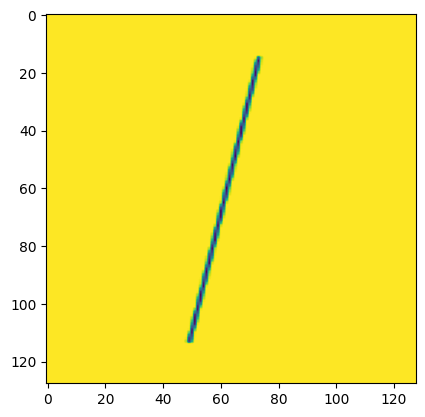

0.99720055


In [155]:
plt.imshow(selected)
plt.show()
print(selected.max())

In [156]:
selected = np.array(selected * 255, dtype=np.uint8)

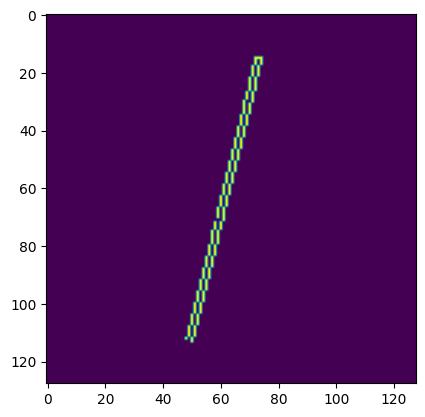

In [157]:
edges = cv2.Canny(selected,0.2,1)
plt.imshow(edges)

In [159]:
for imgs, masks in test_dataloader:
    break
selected = imgs[0]

In [163]:
selected = selected.detach().numpy()

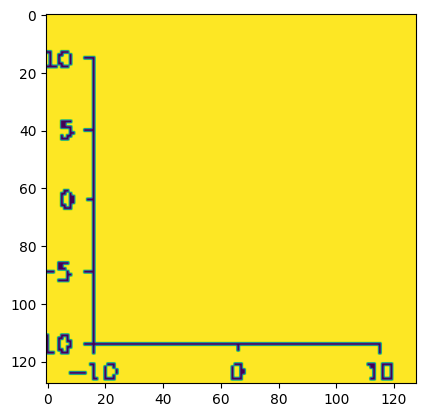

In [166]:
plt.imshow(selected[2])

# Polinomial

Text(0.5, 0, 'X-label')

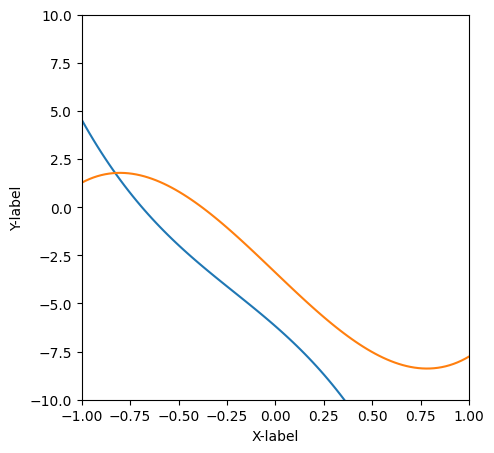

In [65]:
x = np.linspace(-1, 1, 100)

fig, ax = plt.subplots(figsize=(5, 5))

coefs = np.random.uniform(-10, 10, 4)
y = np.poly1d(coefs)
ax.plot(x, y(x))

coefs = np.random.uniform(-10, 10, 4)
y = np.poly1d(coefs)
ax.plot(x, y(x))

ax.set_xlim(-1, 1)
ax.set_ylim(-10, 10)

ax.set_ylabel("Y-label")
ax.set_xlabel("X-label")

# MakeFit

In [32]:
from models_zoo.unet import UNet
from data.data import create_dataloader
from utils import load_model

In [19]:
model = UNet()
model = load_model(model, "21-41-30-07-2024.pth")
test_dataloader = create_dataloader(mode="test", num_samples=128, batch_size=32, shuffle=False, img_size=128)
img, mask = next(iter(test_dataloader))

Models is loaded from:  intermediate.pth
128


128


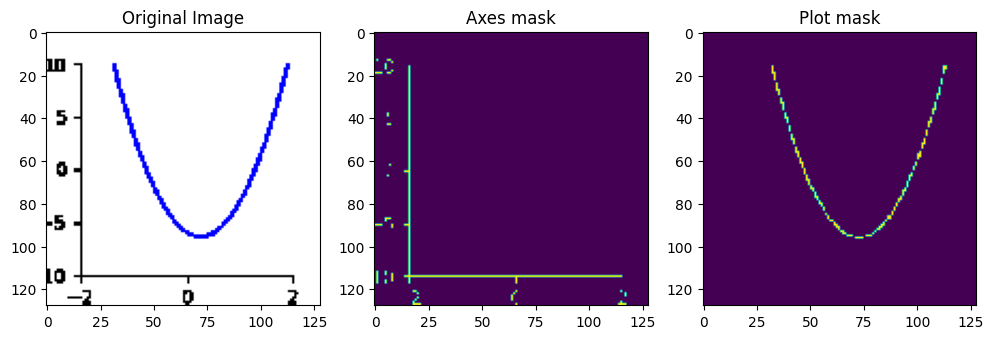

In [30]:
test_dataloader = create_dataloader(mode="test", num_samples=128, batch_size=32, shuffle=False, img_size=128)
img, mask = next(iter(test_dataloader))

n = 3
img = img[n]
mask = mask[n]
_, ax = plt.subplots(1, 3, figsize = (12, 4))
ax[0].imshow(np.transpose(img, (1, 2, 0)))
ax[0].set_title("Original Image")
ax[1].imshow(mask[0])
ax[1].set_title("Axes mask")
ax[2].imshow(mask[1])
ax[2].set_title("Plot mask")
plt.show()

Models is loaded from:  ./res_imgs/08-07-14-30/intermediate.pth
Models is loaded from:  ./res_imgs/08-07-13-36/intermediate.pth


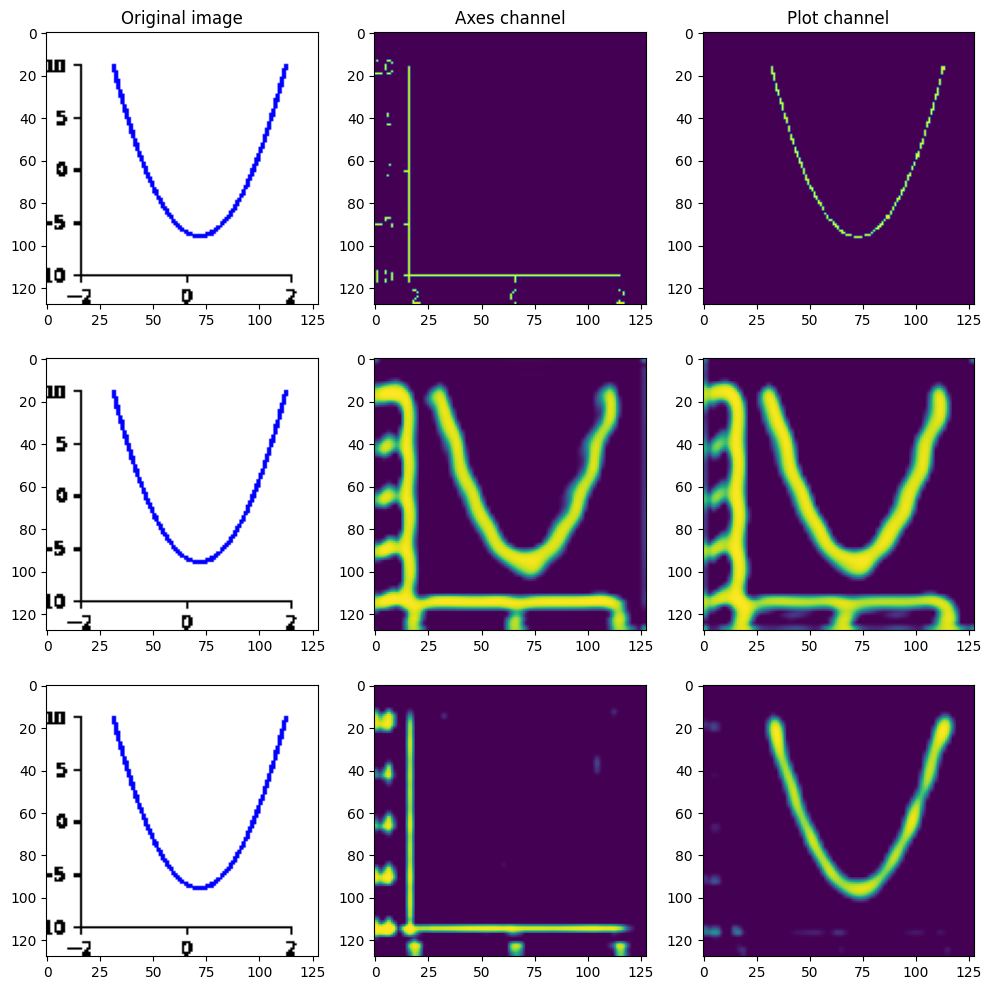

In [44]:
model = UNet()

_, ax = plt.subplots(3, 3, figsize = (12, 12))

img, mask = next(iter(test_dataloader))
weight = "./res_imgs/08-07-14-30/intermediate.pth"
model = load_model(model, weight)
pred1 = model(img).detach().numpy()[n]
weight = "./res_imgs/08-07-13-36/intermediate.pth"
model = load_model(model, weight)
pred2 = model(img).detach().numpy()[n]
img = img[n]
mask = mask[n]
ax[0][0].imshow(np.transpose(img, (1, 2, 0)))
ax[0][0].set_title("Original image")
ax[0][1].imshow(mask[0])
ax[0][1].set_title("Axes channel")
ax[0][2].imshow(mask[1])
ax[0][2].set_title("Plot channel")

ax[1][0].imshow(np.transpose(img, (1, 2, 0)))
ax[1][1].imshow(pred1[0])
ax[1][2].imshow(pred1[1])

ax[2][0].imshow(np.transpose(img, (1, 2, 0)))
ax[2][1].imshow(pred2[0])
ax[2][2].imshow(pred2[1])
plt.show()

In [37]:
pred = model(img)

In [38]:
from scipy.optimize import curve_fit

class FitExtract():

    def __init__(self) -> None:
        pass

    def rescale(self, dictx):
        rescaled = {}
        for key in dictx:
            new_key = (key - 66) / 24
            rescaled[new_key] = ((-1) * dictx[key] + 61) / 4
        return rescaled

    def find_plots(self, image):
        ty, tx = np.where(image > 0.9)
        t = zip(tx, ty)
        tx_set = set(tx)
        t_dict ={ti:[] for ti in tx_set}
        for x, y in t:
            t_dict[x].append(y)
        return t_dict

    def average(self, t_dict):
        t_mean = {ti:np.mean(t_dict[ti]) for ti in t_dict.keys()}
        return t_mean

    def extracted(self, t_dict):
        t_mean = self.average(t_dict)
        t_rescaled = self.rescale(t_mean)
        return t_rescaled

    def superposition(self, x, a11, a12, a13):
        y1 = np.poly1d([a11, a12, a13])
        return y1(x)

    def fit(self, t_rescaled):
        x_values = np.array(list(t_rescaled.keys()))
        y_values = np.array(list(t_rescaled.values()))
        bnds = [(-8, -8, -8), (8, 8, 8)]
        coefficients, _ = curve_fit(self.superposition, x_values, y_values, bounds=bnds)
        return coefficients

    def fit_on(self, pred):
        t_dict = self.find_plots(pred)
        t_rescaled = self.extracted(t_dict)
        coefs = self.fit(t_rescaled)
        return coefs

fit_machine = FitExtract()

In [41]:
coefs = np.zeros((2, 3))
selected_c = pred[0][1].detach().numpy()
coefs[0] = fit_machine.fit_on(selected_c)
selected_c = pred[6][1].detach().numpy()
coefs[1] = fit_machine.fit_on(selected_c)

In [35]:
coef_c = np.load("./data/test/coefs.npy")
coef_c[0]

array([-4.61919436,  0.1046029 ,  5.31208761])

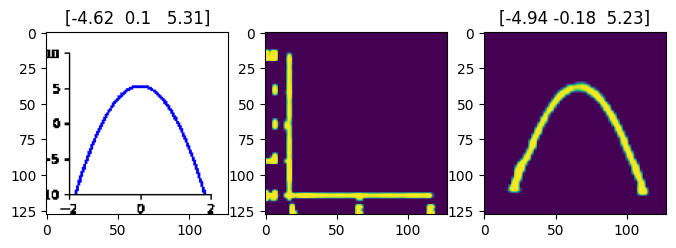

In [46]:
_, axes = plt.subplots(1, 3, figsize=(8, 8))
axes = axes.ravel()
n = 0
axes[0].imshow(np.transpose(img[n], (1,2,0)))
axes[0].set_title(f"{coef_c[n].round(2)}")
axes[1].imshow(pred[n][0].detach().numpy())
axes[2].imshow(pred[n][1].detach().numpy())
axes[2].set_title(f"{coefs[0].round(2)}")
# n = 6
# axes[2].imshow(np.transpose(img[n], (1,2,0)))
# axes[2].set_title(f"{coef_c[n].round(2)}")
# axes[3].imshow(pred[n][1].detach().numpy())
# axes[3].set_title(f"{coefs[1].round(2)}")

plt.show()

In [4]:
import numpy as np
import torch


a = torch.tensor([[10, 16], [10, 16]], dtype=torch.float64)
b = torch.tensor([[13,13], [13, 13]], dtype=torch.float64)

print(torch.nn.MSELoss()(a, b))

tensor(9., dtype=torch.float64)


In [9]:
a = torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=torch.float64)
torch.where(a == 1)

(tensor([0, 1, 2]), tensor([0, 1, 2]))

In [11]:
import torch
import torch.nn as nn

class CustomMSE(nn.Module):
    def __init__(self):
        super(CustomMSE, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, logits, targets):
        # Assume logits and targets are of shape (batch_size, channels, height, width)
        batch_size, channels, height, width = logits.shape
        mse_loss = 0

        for batch in range(batch_size):
            for channel in range(channels):
                targets_ch = targets[batch, channel, :, :]
                logits_ch = logits[batch, channel, :, :]

                # Calculate loss for pixels where target is close to 1
                mask_pos = targets_ch > 0.9
                if torch.any(mask_pos):  # Ensure there are pixels to compare
                    mse_loss += self.mse(logits_ch[mask_pos], targets_ch[mask_pos])

                # Calculate loss for pixels where target is exactly 0
                mask_neg = targets_ch == 0
                if torch.any(mask_neg):  # Ensure there are pixels to compare
                    mse_loss += self.mse(logits_ch[mask_neg], targets_ch[mask_neg])

        # Average the loss over the batch size and channels
        return mse_loss / (batch_size * channels)

# Example usage
logits = torch.rand((2, 2, 5, 5))  # Random predicted logits
targets = torch.randint(0, 2, (2, 2, 5, 5))  # Random binary targets

loss_fn = CustomMSE()
loss = loss_fn(logits, targets)
print("Loss:", loss.item())


Loss: 0.7556914687156677


# DrawingLines

In [97]:
from models_zoo.unet import UNet
from data.data import create_dataloader
from utils import load_model

In [99]:
%matplotlib inline

In [101]:
model = UNet()
model = load_model(model, "08-09-07-16.pth")
test_dataloader = create_dataloader(mode="test", num_samples=128, batch_size=32, shuffle=False, img_size=128)
img, mask = next(iter(test_dataloader))

Models is loaded from:  08-09-07-16.pth
128


In [103]:
pred = model(img).detach().numpy()
print(pred.shape)

(32, 2, 128, 128)


In [104]:
pred.max()

0.99999726

In [105]:
preds = pred[1][1]

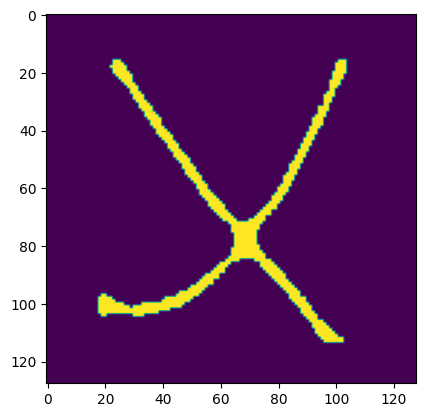

In [111]:
n = 14
my_img = pred[n][1] # + np.roll(np.roll(pred[n][1], -40, axis=0), -0, axis=1)
my_img[my_img < 0.8] = 0
my_img[my_img > 0.5] = 1
my_img = np.roll(my_img, 0, axis=1)
plt.imshow(my_img)
plt.show()

12


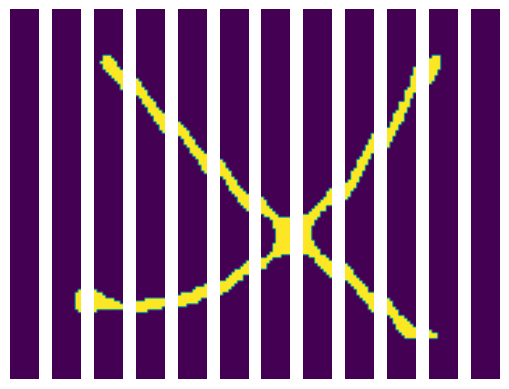

In [113]:
p_size = 10
n_piece = int(128 / p_size)
print(n_piece)

_, ax = plt.subplots(1, n_piece)
for i in range(n_piece):
    piece = my_img[:, i*p_size:(i+1)*p_size]
    ax[i].imshow(piece)
    ax[i].axis("off")

In [115]:
from sklearn.cluster import KMeans

def get_cetners(img, n_of_plots):
    y, x = np.where(img)
    kmeans = KMeans(n_clusters=n_of_plots)
    kmeans.fit(np.column_stack((x, y)))
    return kmeans.cluster_centers_

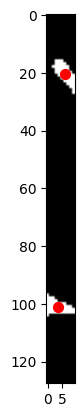

In [117]:
step = 2
centers = get_cetners(my_img[:, step*p_size:(step+1)*p_size], 2)

# Plot the results
plt.imshow(my_img[:, step*p_size:(step+1)*p_size], cmap='gray')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50)
plt.show()

In [123]:
kalman_filters = [cv2.KalmanFilter(4, 2) for _ in range(2)]

for kf in kalman_filters:
    kf.transitionMatrix = np.array([[1, 0, 1, 0],
                                    [0, 1, 0, 1],
                                    [0, 0, 1, 0],
                                    [0, 0, 0, 1]], dtype=np.float32)
    kf.measurementMatrix = np.array([[1, 0, 0, 0],
                                     [0, 1, 0, 0]], dtype=np.float32)
    kf.processNoiseCov = np.eye(4, dtype=np.float32) * 1e-2
    kf.measurementNoiseCov = np.eye(2, dtype=np.float32) * 1e-1
    kf.errorCovPost = np.eye(4, dtype=np.float32)

In [125]:
# Initialize the state estimate (initial position and velocity)
step_0 = 2
centers = get_cetners(my_img[:, step_0*p_size:(step_0+1)*p_size], n_of_plots=2)
for i, kf in enumerate(kalman_filters):
    kf.statePost = np.array([centers[i][0], centers[i][1], 0, 0], dtype=np.float32)

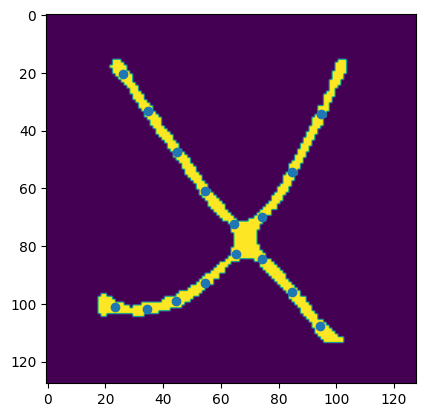

In [127]:
kalman_predictions = []
real_centers = []
for i in range(2, 10):
    piece = my_img[:, i*p_size:(i+1)*p_size]
    centers = get_cetners(piece, 2)
    centers += np.array([i*p_size, 0])
    real_centers.append(centers)
    for i, kf in enumerate(kalman_filters):
        kf.predict()
        kalman_predictions.append(kf.statePost[:2])
        kf.correct(np.array(centers[i], dtype=np.float32))
kalman_predictions = np.array(kalman_predictions).reshape(16, 2)
real_centers = np.array(real_centers).reshape(16, 2)
plt.imshow(my_img)
plt.scatter(real_centers[:, 0], real_centers[:, 1])
plt.show()

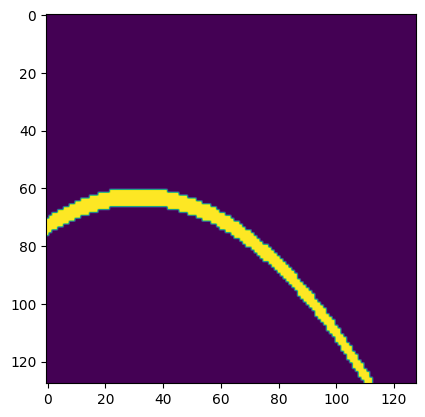

In [208]:
def plot_parabolas(width, height, thickness):
    grid = np.zeros((height, width))

    x = np.linspace(-width // 2, width // 2, width)
    
    # First parabola parameters (opens downwards)
    a1, h1, k1 = 0.01, -width // 4, height // 2
    y1 = a1 * (x - h1)**2 + k1

    # Second parabola parameters (opens upwards)
    a2, h2, k2 = -0.01, width // 4, height // 2
    y2 = a2 * (x - h2)**2 + k2

    for i in range(width):
        for dy in range(-thickness // 2, thickness // 2 + 1):
            y_pos1 = int(y1[i] + dy)
            y_pos2 = int(y2[i] + dy)
            if 0 <= y_pos1 < height:
                grid[y_pos1, i] = 1
            # if 0 <= y_pos2 < height:
            #     grid[y_pos2, i] = 1

    return grid

# Parameters
width, height = 128, 128
thickness = 5

# Generate the image
image = plot_parabolas(width, height, thickness)
plt.imshow(image)

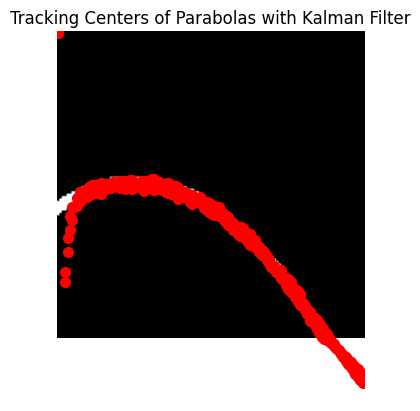

In [210]:
# Split image into vertical segments
n_of_plots = 2
n_segments = 128
segment_width = width // n_segments

# Store centers for visualization
centers_all_segments = []

# Initialize Kalman filters for two parabola centers
kalman_filters = [cv2.KalmanFilter(4, 2) for _ in range(n_of_plots)]

for kf in kalman_filters:
    # Define the state transition matrix (constant velocity model)
    kf.transitionMatrix = np.array([[1, 0, 1, 0],
                                    [0, 1, 0, 1],
                                    [0, 0, 1, 0],
                                    [0, 0, 0, 1]], dtype=np.float32)
    
    # Define the measurement matrix (identity matrix for (x, y))
    kf.measurementMatrix = np.array([[1, 0, 0, 0],
                                     [0, 1, 0, 0]], dtype=np.float32)

    # Initialize process noise covariance matrix
    kf.processNoiseCov = np.eye(4, dtype=np.float32) * 1e-2
    
    # Initialize measurement noise covariance matrix
    kf.measurementNoiseCov = np.eye(2, dtype=np.float32) * 1e-1
    
    # Initialize error covariance post
    kf.errorCovPost = np.eye(4, dtype=np.float32)

# Process each segment
for seg_idx in range(2, n_segments):
    x_start = seg_idx * segment_width
    x_end = x_start + segment_width
    segment = image[:, x_start:x_end]

    # Get coordinates of non-zero pixels (edge points)
    y, x = np.where(segment == 1)
    x = x + x_start  # Adjust x to match global coordinates

    if seg_idx == 0:
        # Apply KMeans to the first segment
        kmeans = KMeans(n_clusters=n_of_plots)  # Assuming two parabolas
        kmeans.fit(np.column_stack((x, y)))
        centers = kmeans.cluster_centers_
        
        # Initialize Kalman filters with these centers
        for i, center in enumerate(centers):
            kalman_filters[i].statePre = np.array([center[0], center[1], 0, 0], dtype=np.float32)
            #kalman_filters[i].statePost = np.array([center[0], center[1], 0, 0], dtype=np.float32)
    else:
        # Predict new centers using Kalman filters
        centers = []
        for kf in kalman_filters:
            pred = kf.predict()
            centers.append(pred[:2])

        # Use KMeans to get the measurement
        kmeans.fit(np.column_stack((x, y)))
        for i, kf in enumerate(kalman_filters):
            measured_center = kmeans.cluster_centers_[i].astype(np.float32).reshape(-1, 1)
            # Update Kalman filter with the measurement
            kf.correct(measured_center)

    # Store centers for visualization
    centers_all_segments.append(centers)

# Visualize results
plt.imshow(image, cmap='gray')
for centers in centers_all_segments:
    for center in centers:
        plt.scatter(center[0], center[1], c='red', s=50, zorder=5)
plt.title('Tracking Centers of Parabolas with Kalman Filter')
plt.axis('off')
plt.show()

In [371]:
centers_all_segments

[array([[12.  , 67.42],
        [20.26,  5.88]]),
 [array([109.925186, 119.93412 ], dtype=float32),
  array([108.86491 ,  63.744904], dtype=float32)],
 [array([109.925186, 119.93412 ], dtype=float32),
  array([108.86491 ,  63.744904], dtype=float32)],
 [array([109.925186, 119.93412 ], dtype=float32),
  array([108.86491 ,  63.744904], dtype=float32)],
 [array([109.925186, 119.93412 ], dtype=float32),
  array([108.86491 ,  63.744904], dtype=float32)]]